<a href="https://colab.research.google.com/github/marathomas/meerkat/blob/master/meerkat_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Meerkat Preprocessing

In this script, I am preprocessing audio data so that I can reproduce the unsupervised clustering analysis performed by Gentner et al. 2019 (https://www.biorxiv.org/content/10.1101/870311v1.full.pdf) with meerkat vocalizations. I am planning to use the functions made available by Tim Sainsberg (https://github.com/timsainb/avgn_paper), a package called AVGN that should allow me to reproduce the analyses in the paper. Therefore, I need to bring my data into the format that is necessary to run the AVGN analysis functions.

## Prerequisites

- Project folder should already exist, save path as PROJECT_PATH
- Project folder must contain subfolder called "in_labels", containing all label tables in csv format 
- Project folder must contain subfolder called "in_wavs", containing all audio files

### Mounting drive

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Or select "Mount Drive" in Files menu!

### Installing and loading libraries

(software installations within Google Colaboratory are not persistent, need to reinstall libraries every time you (re-)connect to an instance)

In [5]:
import os
os.system('pip install pydub') # need to install
import pandas as pd
import sys
import re
import json
from IPython.display import Audio 
os.system('pip install "librosa==0.7.1"')
import librosa
from pydub import AudioSegment
import matplotlib.pyplot as plt
import librosa.display
import numpy as np
import os
import statistics
import matplotlib.pyplot as plt
#from datetime import time
#from datetime import datetime
import glob
from pandas.core.common import flatten
import shutil
import pickle
os.system('pip install noisereduce') # need to install
import noisereduce as nr
os.system('pip install pathlib2') # need to install
import pathlib2
import psutil
import re
import datetime

/usr/local/lib/python3.6/dist-packages/noisereduce/noisereduce.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


### Setting constants

Setting project, input and output folders.

In [0]:
# these directories should already exist
PROJECT_PATH = "/content/drive/My Drive/meerkat/" 
AUDIO_IN = PROJECT_PATH+"in_wavs/" 
LABELS_IN = PROJECT_PATH+"in_labels/" 

# these directories are created during execution
LABELS_OUT = PROJECT_PATH+"labels/"
FIGURES = PROJECT_PATH+"figs/"

dirs2create = [LABELS_OUT, FIGURES]

Constants for parsing label files:

- column names in labels CSV that indicate start and duration
- irrelevant labels that are discarded in the process (labels for beeps, noise, synch calls..)
- minimum call duration in ms

In [0]:
START_COL = 'Start'
DUR_COL = 'Duration'

IRRELEVANT_LABELS = ['SYNCH', 
                     'START', 
                     'END',
                     'STOP',
                     'SKIP', 
                     'NOISE', 
                     'BEEP', 
                     'CHEW',
                     'X',
                     'HYB',
                     'HYBRID',
                     'UKN',
                     'UNKNOWN',
                     'FU',
                     'LOST',
                     'OTHER',
                     'OTH',
                     'LC',
                     'SQ',
                     'STOP',
                     'SKIP',
                     'NF',
                     'NONFOC']
IRRELEVANT_LABELS = IRRELEVANT_LABELS+[item.lower() for item in IRRELEVANT_LABELS]

MIN_DURATION = 0.1
GROUP = 'HM'

### Installing AVGN

Cloning the AVGN_paper repository:

In [6]:
os.chdir(PROJECT_PATH)

if (not os.path.exists(PROJECT_PATH+'avgn_paper')):
  print("Cloning Repo")
  os.mkdir("avgn_paper")
  os.chdir("avgn_paper")
  os.sytem('git clone https://github.com/timsainb/avgn_paper.git')
else:
  print("Repo already present")
  os.chdir("avgn_paper")

Repo already present


In [7]:
os.system('python setup.py develop')

0

In [0]:
from importlib.machinery import SourceFileLoader
avgn = SourceFileLoader('avgnpaper/avgn', PROJECT_PATH+'avgn_paper/avgn/'+'utils/__init__.py').load_module()
import avgn

### Loading AVGN libraries

For some parts of the preprocessing script, I use the original functions from Sainsberg:

In [9]:
# spectrogramming
from avgn.utils.hparams import HParams 
from avgn.signalprocessing.create_spectrogram_dataset import prepare_wav, create_label_df, get_row_audio
from avgn.signalprocessing.filtering import butter_bandpass_filter 
from tqdm.autonotebook import tqdm
from avgn.visualization.spectrogram import draw_spec_set


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Creating output directories

In [0]:
os.chdir(PROJECT_PATH)

for dirpath in dirs2create:
  if not os.path.exists(os.path.basename(dirpath[:-1])):
    os.mkdir(os.path.basename(dirpath[:-1]))

## Functions

What I need are short .wav files, each containing one single vocalization of a meerkat. What I have are long .wav files, containing many vocalizations and periods of silence (noise), and a label file (CSV) indicating at what time vocalisations occur (and what type of vocalisation they are). In addition, I need a JSON metadata file for each vocalization .wav file.

In [0]:
os.chdir(PROJECT_PATH)

### General

In [0]:
# Function that gets fileID from csv filename
# Input: csv_filename (not path!) (String)
# Output: csv_filename up to the last numeric character

def fileID_from_csv_filename(csv_in):
  csv_in = csv_in[::-1]  # reverse string
  def rem_nonnumeric(str): # removes everything up to the first numeric char
    foundDigit=False
    pos=0
    for char in str:
      if(char.isdigit()):
        return(str[pos:])
      pos=pos+1
    return str 
  csv_out = rem_nonnumeric(csv_in)
  csv_out = csv_out[::-1] # reverse to normal again
  return (csv_out)

### Functions for preparing label files

First, I'll parse the csv label files into a pandas dataframe. Then, because PyDub segments audio in milliseconds, I have to turn the format h:min:s.ms to ms, so that I have the start and stop times of the calls in milliseconds (f.e. 10032002-10032144)

In [0]:
# Function that gets datatime object from timestring
# timestring must match one of the given time_patterns
# Input: some string containing a time (String)
# Output: datetime object
# Example usage: dt = get_time("01:02:30.555")
def get_time(timestring):
    time_patterns = ['%H:%M:%S.%f', '%M:%S.%f']
    for pattern in time_patterns:
        try:
            return datetime.strptime(timestring, pattern)
        except:
            pass

    print("Date is not in expected format")
    sys.exit(0)

# Function that converts time in datatime object to ms 
# Input: datatime (datatime.datatime)
# Output: time in ms (float)
# Example usage: ms = get_ms(datatime_obj)
def get_s(dt):
  return dt.microsecond/1000000+dt.second + dt.minute*60 + dt.hour*60*60


In [0]:
# Function to get the meerkat ID (alphanumeric String) from filename
# filename is always HM_meerkatID_*.extension
# Input: filename (String)
# Output: meerkat ID (String)
# Example use: get_meerkatID('HM_VHMM003_HLT_AUDIO_R12_file_5_(2017_08_06-06_44_59)_ASWMUX221102.wav')

def get_meerkatID(filename):
  meerkatID = filename.replace(GROUP+'_','')
  meerkatID = str.split(meerkatID, sep='_')[0]
  return meerkatID

# Function to get date from filename
# date in filename must be in one of the three patterns
# Input: filename (String)
# Output: datetime object
# Example use: get_datetime('HM_VHMF001_HTB_R20_20190707-20190719_file_9_(2019_07_15-11_44_59)_155944')

def get_datetime(filename):
  match = re.search('\d{4}-\d{2}-\d{2}', filename)
  if (match):
    date = datetime.strptime(match.group(), '%Y-%m-%d').date()
  else:
    match = re.search('\d{4}_\d{2}_\d{2}', filename)
    if (match):
     date = datetime.strptime(match.group(), '%Y_%m_%d').date() 
    else:
      match = re.search('\d{4}\d{2}\d{2}', filename)
      if(match):
        date = datetime.strptime(match.group(), '%Y%m%d').date()
  return date


In [0]:
def prep_labels(csv_loc, wav_loc, fileID):

  # read in labels
  labels = pd.read_csv(csv_loc, sep="\t")

  # find name of column that contains the labels. Should contain 'Name'
  name_col = [col for col in labels.columns if 'Name' in col]
  if(len(name_col)==1):
    name_col = name_col[0]
    call = ["n" if any(s in i for s in IRRELEVANT_LABELS) else "y" for i in list(labels[name_col])]
    labels['call_yn'] = call
  else:
    print("Cannot find label name column")
  
  # Add start stop s
  if (labels.shape[0]!=0):
    labels['start_s'] = labels.apply(lambda row: get_s(get_time(row['Start'])), axis=1)
    labels['duration_s'] = labels.apply(lambda row: get_s(get_time(row['Duration'])), axis=1)
    labels['stop_s'] = labels['start_s']+labels['duration_s']

    # Add additional data
    labels['date']=[get_datetime(fileID).strftime("%Y-%m-%d")]*labels.shape[0]
    labels['samplerate_hz'] = [librosa.get_samplerate(wav_loc)]*labels.shape[0]
    labels['indv'] = [get_meerkatID(fileID)]*labels.shape[0]
    labels["original_wav"] = [wav_loc]*labels.shape[0]
    labels["bout_number"] = [i for i in range(labels.shape[0])]

  labels = labels.rename(columns={name_col: 'Name'})

  return labels

### Functions for creating spectrograms

In [0]:
# Function that gets audio data (numpy array of amplitude) from wav
# Input: Path to wav file (String) 
#        Audio parameters (Hparams, a custom AVGN object type)
# Output: Amplitude (numpy array)

def get_audio(wav_loc, start_s, duration_s):
  # get rate and date
  data, rate = librosa.load(wav_loc, offset=start_s, duration=duration_s, sr=None)
  if np.issubdtype(type(data[0]), np.integer):
    data = int16_to_float32(data)
  return data

In [0]:
# Function that generates mel spectrogram from audio data
# Input: Audio data (np array of floats), 
#        samplerate in Hz (integer)
#        number of mel bands (integer)
#        spectrogram window generation type (String)
#        window length in s (float)
#        hop between window start in s (float)
# Output: Spectrogram (np array of floats)

def generate_mel_spectrogram(data, rate, n_mels, window, fft_win , fft_hop):
    win_length  = int(fft_win * rate) 
    hop_length = int(fft_hop * rate) 
        
    s = librosa.feature.melspectrogram(y = data ,
                                       sr = rate, 
                                       n_mels = n_mels , 
                                       fmax = rate/2, 
                                       n_fft = win_length,
                                       hop_length = hop_length, 
                                       window = window, 
                                       win_length = win_length)
    spectro = librosa.power_to_db(s, ref=np.max)

    return spectro

## Processing files

### Setting variables

Getting list of csvs and matching wavs

In [0]:
# Getting list of fileIDs, wavs and csvs (fileID, in_wav_loc and in_csv_loc)

in_csv_loc = glob.glob(LABELS_IN+'*.csv') + glob.glob(LABELS_IN+'*.CSV')
csv_filenames = [os.path.basename(csv) for csv in in_csv_loc]

fileIDs = [fileID_from_csv_filename(csv_filename) for csv_filename in csv_filenames]

in_wav_loc = [glob.glob(AUDIO_IN+fileID+'*') for fileID in fileIDs] # creates list of lists
in_wav_loc = [["NA"] if not x else x for x in in_wav_loc] # Replace empty lists with "NA"
in_wav_loc = list(flatten(in_wav_loc)) # Flatten list

### Removing files

Removing files with bad quality and those that contain SOUNDFOC in filename.

In [0]:
badIDs = ['HM_VHMM007_LT_AUDIO_R11_file_5_(2017_08_06-06_44_59)_ASWMUX221163', 
           'HM_VHMM006_RT_AUDIO_R14_file_5_(2017_08_06-06_44_59)_ASWMUX221052']+[i for i in fileIDs if 'SOUNDFOC' in i]

In [0]:
bad_csvs = [glob.glob(LABELS_IN+fileID+'*') for fileID in badIDs]
bad_csvs = list(flatten(bad_csvs))

bad_wavs = []
for bad_csv in bad_csvs:
  bad_wavs.append(in_wav_loc[in_csv_loc.index(bad_csv)])

for bad_csv in bad_csvs:
  in_csv_loc.remove(bad_csv)
for bad_wav in bad_wavs:
  in_wav_loc.remove(bad_wav)
for badID in badIDs:
  fileIDs.remove(badID)


In [21]:
print(str(len(fileIDs))+" files remaining")

82 files remaining


### Preparing label files

In [0]:
for csv, wav, fileID in zip(in_csv_loc, in_wav_loc, fileIDs):
  if not wav=='NA':
    print("Processing "+fileID)
  # Parse labels
    labels = prep_labels(csv, wav, fileID)  
    # If labels is non-empty...
    if (labels.shape[0]!=0):
      labels.to_csv(LABELS_OUT+fileID+"_labels.csv", index=False)
    else:
      print("No labelled calls for "+fileID)
  else:
    print("No wav for "+fileID)

Processing HM_RT_R12_file_6_(2017_08_25-06_44_59)_ASWMUX221102
Processing HM_HRT_R09_AUDIO_file_6_(2017_08_25-06_44_59)_ASWMUX221110
Processing HM_LT_R07_AUDIO_file_6_(2017_08_25-06_44_59)_ASWMUX221092
Processing HM_HTB_R14_file_6_(2017_08_25-06_44_59)_ASWMUX221052
Processing HM_PET_R11_20170903-20170908_file_4_(2017_09_05-05_44_59)_ASWMUX221163
Processing HM_HMB_R11_AUDIO_file_4_(2017_08_23-06_44_59)_ASWMUX221163
Processing HM_RT_R12_file_4_(2017_08_23-06_44_59)_ASWMUX221102
Processing HM_PET_R11_20170903-20170908_file_2_(2017_09_03-05_44_59)_ASWMUX221163
Processing HM_HRT_R09_AUDIO_file_5_(2017_08_24-06_44_59)_ASWMUX221110
Processing HM_LT_R07_AUDIO_file_4_(2017_08_23-06_44_59)_ASWMUX221092
Processing HM_HRT_R09_AUDIO_file_4_(2017_08_23-06_44_59)_ASWMUX221110
Processing HM_RT_R12_file_5_(2017_08_24-06_44_59)_ASWMUX221102
Processing HM_LT_R09_20170903-20170908_file_2_(2017_09_03-05_44_59)_ASWMUX221110
Processing HM_HRT_R07_20170903-20170908_file_2_(2017_09_03-05_44_59)_ASWMUX221092
Pr

In [0]:
print("Generated "+str(len(glob.glob(LABELS_OUT+'*')))+" label files")

Generated 82 label files


### Get updated list of wav and labels file locations

In [0]:
# List of all wav filepaths (to full wav files, not just the calls), where I have 
# a labels file in LABELS_OUT. Therefore, do it kind of backwards.

labels_loc = glob.glob(LABELS_OUT+'*.csv')
fileIDs = [os.path.basename(item).replace('_labels.csv', '') for item in labels_loc] 

wavs_loc = [glob.glob(AUDIO_IN+fileID+'*') for fileID in fileIDs] # creates list of lists
wavs_loc = [["NA"] if not x else x for x in wavs_loc] # Replace empty lists with "NA"
wavs_loc = list(flatten(wavs_loc)) # Flatten list

# check for NAs, should be none!
for ID, wav in zip(fileIDs, wavs_loc):
  if wav=="NA":
    print("Error, wav file missing for"+label)


### Make a dataset dataframe

In [0]:
df_list=[]

for label_loc in labels_loc:
  print("Generating label df for "+os.path.basename(label_loc))
  df_list.append(pd.read_csv(label_loc))

df = pd.concat(df_list)

Generating label df for HM_RT_R12_file_6_(2017_08_25-06_44_59)_ASWMUX221102_labels.csv
Generating label df for HM_HRT_R09_AUDIO_file_6_(2017_08_25-06_44_59)_ASWMUX221110_labels.csv
Generating label df for HM_LT_R07_AUDIO_file_6_(2017_08_25-06_44_59)_ASWMUX221092_labels.csv
Generating label df for HM_HTB_R14_file_6_(2017_08_25-06_44_59)_ASWMUX221052_labels.csv
Generating label df for HM_PET_R11_20170903-20170908_file_4_(2017_09_05-05_44_59)_ASWMUX221163_labels.csv
Generating label df for HM_HMB_R11_AUDIO_file_4_(2017_08_23-06_44_59)_ASWMUX221163_labels.csv
Generating label df for HM_RT_R12_file_4_(2017_08_23-06_44_59)_ASWMUX221102_labels.csv
Generating label df for HM_PET_R11_20170903-20170908_file_2_(2017_09_03-05_44_59)_ASWMUX221163_labels.csv
Generating label df for HM_HRT_R09_AUDIO_file_5_(2017_08_24-06_44_59)_ASWMUX221110_labels.csv
Generating label df for HM_LT_R07_AUDIO_file_4_(2017_08_23-06_44_59)_ASWMUX221092_labels.csv
Generating label df for HM_HRT_R09_AUDIO_file_4_(2017_08_2

In [0]:
df.index = list(range(0,df.shape[0]))

In [0]:
df.shape

(39404, 16)

### Creating the spectrograms

Creating spectrograms from call files and put them as numpy array into labels dataframe. First, remove all signals that are not calls and all calls that are too short.



In [0]:
spec_df = df.loc[df['call_yn']=="y"]
spec_df.shape

(22855, 16)

In [0]:
spec_df = spec_df.loc[df['duration_s'] >= MIN_DURATION]
spec_df.shape

(12490, 16)

In [0]:
spec_df.index = list(range(0,spec_df.shape[0]))

#### Setting parameters

In [0]:
FFT_WIN = 0.03
FFT_HOP = FFT_WIN/8
N_MELS = 40
WINDOW = 'hann'
WIN_LENGTH = 6

#### Getting audio data

In [0]:
raw_audio_data = spec_df.apply(lambda row: get_audio(row['original_wav'], row['start_s'], row['duration_s']), axis=1)
spec_df['raw_audio'] = raw_audio_data
spec_df.to_pickle(PROJECT_PATH+"spec_df_all")

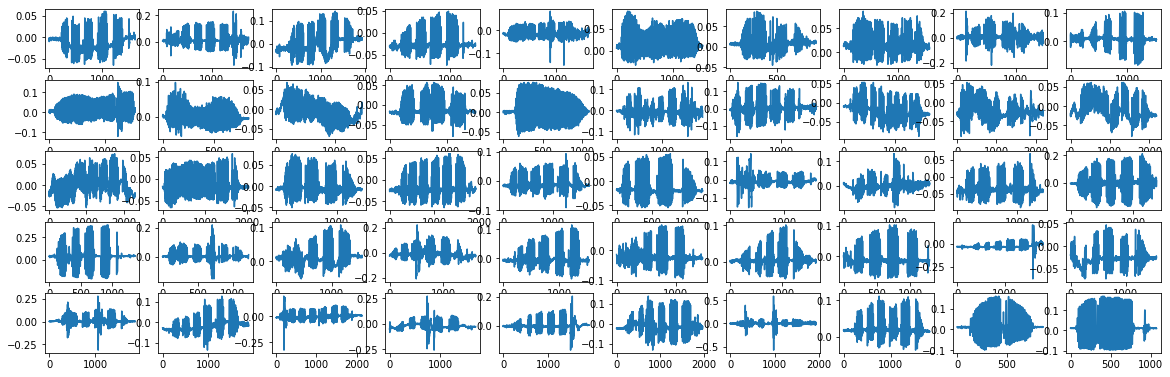

In [0]:
subset_df = spec_df.loc[0:50,]
sylls = subset_df.raw_audio.values

nrows = 5
ncols = 10
zoom = 2
fig, axs = plt.subplots(ncols=ncols, nrows = nrows,figsize = (ncols*zoom, nrows+zoom/1.5))
for i, syll in tqdm(enumerate(sylls), total = nrows*ncols):
    ax = axs.flatten()[i]
    ax.plot(syll)
    if i == nrows*ncols -1:
        break

#### Spectrogramming

In [0]:
spec_df = pd.read_pickle(PROJECT_PATH+"spec_df_all")

In [0]:
spectrograms = spec_df.apply(lambda row: generate_mel_spectrogram(row['raw_audio'], 
                                                             row['samplerate_hz'], 
                                                             N_MELS, 
                                                             WINDOW, 
                                                             FFT_WIN , 
                                                             FFT_HOP), 
                        axis=1)

spec_df['spectrograms'] = spectrograms
spec_df.to_pickle(PROJECT_PATH+"spec_df_all")

Visualize the first 50 spectrograms

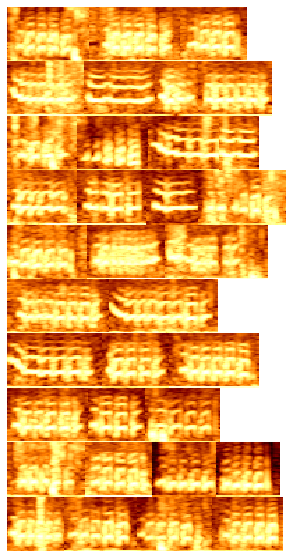

In [0]:
df_subset = spec_df.iloc[1:50,]
specs = df_subset.spectrograms.values
draw_spec_set(specs, zoom=1, maxrows=10, colsize=5)
plt.show()

# UMAP Projection

In [0]:
import umap
from avgn.signalprocessing.create_spectrogram_dataset import flatten_spectrograms
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [0]:
def norm(x):
    return (x-np.min(x)) / (np.max(x) - np.min(x))

In [0]:
def pad_spectro(spec,maxlen):
  padding = maxlen - spec.shape[1]
  z = np.zeros((spec.shape[0],padding))
  padded_spec=np.append(spec, z, axis=1)
  return padded_spec

In [0]:
spec_df = pd.read_pickle(PROJECT_PATH+"spec_df_all")

Remove the rare, long calls

(array([6.212e+03, 3.468e+03, 1.371e+03, 5.490e+02, 2.400e+02, 1.390e+02,
        9.800e+01, 7.700e+01, 5.700e+01, 5.300e+01, 4.100e+01, 2.600e+01,
        3.300e+01, 2.400e+01, 1.700e+01, 1.300e+01, 1.300e+01, 1.400e+01,
        7.000e+00, 7.000e+00, 6.000e+00, 2.000e+00, 3.000e+00, 2.000e+00,
        1.000e+00, 1.000e+00, 2.000e+00, 2.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 2.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

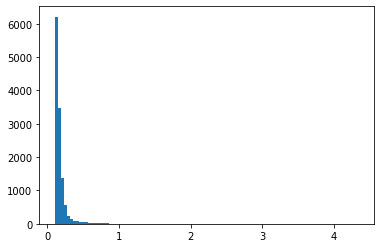

In [32]:
plt.hist(spec_df['duration_s'], bins=100)

In [0]:
MAX_DURATION=0.5

In [34]:
spec_df = spec_df.loc[spec_df['duration_s'] <= MAX_DURATION]
spec_df.shape

(12234, 18)

In [0]:
specs = spec_df.spectrograms.values # now 2D arrays n_mels+time_frames(varying)

In [0]:
maxlen= np.max([spec.shape[1] for spec in specs])

In [0]:
flattened_specs = [pad_spectro(spec, maxlen).flatten() for spec in specs]
specs_arr = np.asarray(flattened_specs)
df = pd.DataFrame(specs_arr)

In [0]:
reducer = umap.UMAP()

In [0]:
spectro_data = StandardScaler().fit_transform(df)

In [0]:
embedding = reducer.fit_transform(spectro_data)

In [0]:
z  = list(embedding)

In [0]:
z = np.vstack(z)

In [0]:
from avgn.visualization.projections import scatter_spec
from avgn.utils.general import save_fig
from avgn.utils.paths import FIGURE_DIR, ensure_dir

In [106]:
specs = [i - np.min(i) for i in tqdm(specs)]

TypeError: ignored

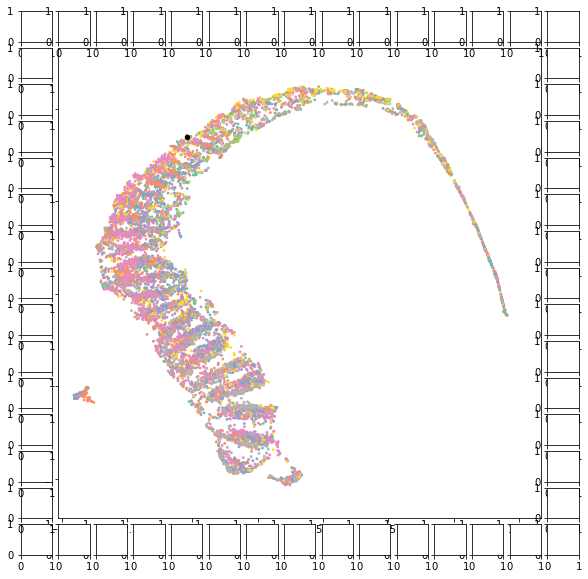

In [109]:
scatter_spec(
    z,
    specs_flattened,
    column_size=15,
    #x_range = [-5.5,7],
    #y_range = [-10,10],
    pal_color="hls",
    color_points=False,
    enlarge_points=20,
    figsize=(10, 10),
    scatter_kwargs = {
        'labels': spec_df.indv.values,
        'alpha':1.0,
        's': 3,
        "color_palette": 'Set2',
        'show_legend': False
    },
    matshow_kwargs = {
        'cmap': plt.cm.Greys
    },
    line_kwargs = {
        'lw':1,
        'ls':"solid",
        'alpha':0.25,
    },
    draw_lines=True
);
save_fig(PROJECT_PATH+'meerkat_calls', dpi=300, save_jpg=True)

# Code-Reste

### Checking what files are present

In [0]:
jsons = os.listdir(JSON_OUT)
audios = os.listdir(AUDIO_OUT)

print(len(jsons))
print(len(audios))

print(jsons[4])
print(audios[4])

#jsons = [os.path.basename(json)[:-5] for json in jsons]
#audios = [os.path.basename(audio)[:-4] for audio in audios]

jsons = [os.path.basename(json).split('.')[0] for json in jsons]
audios = [os.path.basename(audio).split('.')[0] for audio in audios]


print(jsons[4])
print(audios[4])


diffs = pd.Series(list(set(audios).difference(list(set(jsons)))))
print("In audios, but not in jsons:"+str(diffs.size))

diffs = pd.Series(list(set(jsons).difference(list(set(audios)))))
print("In jsons, but not in audios:"+str(diffs.size))

2671
2671
HM_VHMM023_MBLS_R02_20190707-20190719_file_9_(2019_07_15-11_44_59)_155944_call58.JSON
HM_VHMM023_MBLS_R02_20190707-20190719_file_9_(2019_07_15-11_44_59)_155944_call31.wav
HM_VHMM023_MBLS_R02_20190707-20190719_file_9_(2019_07_15-11_44_59)_155944_call58
HM_VHMM023_MBLS_R02_20190707-20190719_file_9_(2019_07_15-11_44_59)_155944_call31
In audios, but not in jsons:0
In jsons, but not in audios:0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


In [0]:
print(len(jsons))
print(len(list(set(jsons))))


print(len(audios))
print(len(list(set(audios))))

2671
2671
2671
2671


In [0]:
print(diffs.values)

['HM_VHMF019_MBTB_R25_20190707-20190719_file_9_(2019_07_15-11_44_59)_155944_call20.wav']


In [0]:
glob.glob(AUDIO_OUT+'HM_VHMF019_MBTB_R25_20190707-20190719_file_9_(2019_07_15-11_44_59)_155944_call20.wav')

['/content/drive/My Drive/meerkat/segmented_audios/HM_VHMF019_MBTB_R25_20190707-20190719_file_9_(2019_07_15-11_44_59)_155944_call20.wav']

In [0]:
glob.glob(JSON_OUT+'HM_VHMF019_MBTB_R25_20190707-20190719_file_9_(2019_07_15-11_44_59)_155944_call20*')

['/content/drive/My Drive/meerkat/json_files/HM_VHMF019_MBTB_R25_20190707-20190719_file_9_(2019_07_15-11_44_59)_155944_call20.JSON',
 '/content/drive/My Drive/meerkat/json_files/HM_VHMF019_MBTB_R25_20190707-20190719_file_9_(2019_07_15-11_44_59)_155944_call20.wav.JSON']

In [0]:
audios = os.listdir(AUDIO_OUT)
print(len(audios))
print(len(list(set(audios))))

2671
2671


In [0]:
audios.count('HM_VHMF019_MBTB_R25_20190707-20190719_file_9_(2019_07_15-11_44_59)_155944_call20.wav')

1

In [0]:
os.remove('/content/drive/My Drive/meerkat/json_files/HM_VHMF019_MBTB_R25_20190707-20190719_file_9_(2019_07_15-11_44_59)_155944_call20.wav.JSON')

In [0]:
# Checking which files are uploaded and which aren't even though they should have been

years = ['2017', '2019']

for year in years:
  print("Year is: "+year)
  matching = pd.read_csv(PROJECT_PATH+"/matching_"+year+".txt", sep="\t", header=None)
  matching.columns = ['name', 'wav', 'csv']

  print(matching.shape)
  matching = matching.dropna()
  print("After dropping NA:")
  print(matching.shape)

  wavs_file = [os.path.basename(x) for x in matching['wav']]
  if(year=='2017'):
    audio_dir = AUDIO_IN
  elif(year=='2019'):
    audio_dir = PROJECT_PATH+'matched_wavs_2019'
  
  wavs_drive = os.listdir(audio_dir)

  if(len(set(wavs_drive))==len(wavs_drive)):
    print("No duplicates")
  else:
    print("Duplicates!")

  diffs = pd.Series(list(set(wavs_drive).difference(set(wavs_file))))
  print("In drive, but not in file:"+str(diffs.size))
  print(diffs)

  diffs = pd.Series(list(set(wavs_file).difference(set(wavs_drive))))
  print("In file, but not in drive:"+str(diffs.size))
  print(diffs)
  diffs.to_csv(PROJECT_PATH+'diffs'+year+'.csv', sep=";")


Year is: 2017
(51, 3)
After dropping NA:
(45, 3)
No duplicates
In drive, but not in file:0
Series([], dtype: float64)
In file, but not in drive:0
Series([], dtype: float64)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


Year is: 2019
(65, 3)
After dropping NA:
(65, 3)
No duplicates
In drive, but not in file:0
Series([], dtype: float64)
In file, but not in drive:0
Series([], dtype: float64)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


### Moving files into different folders

In [0]:
os.chdir(PROJECT_PATH)

In [0]:
print(len(os.listdir("in_wavs")))
print(len(os.listdir("matched_wavs_2019")))

In [0]:
# move all files from matched_wavs_2019 into in_wavs
files2move = os.listdir("matched_wavs_2019")
for f in files2move:
  shutil.move(PROJECT_PATH+'matched_wavs_2019/'+f, 'in_wavs')

os.rmdir(PROJECT_PATH+'matched_wavs_2019')

### Removing bad quality

Should remove all files that are not usable for the analysis because later steps in the preprocessing are not written to handle missing files that are usually created during preprocessing.

Need to remove those with low quality, these are:
- HM_VHMM007_LT_AUDIO_R11_file_5_(2017_08_06-06_44_59)_ASWMUX221163
- HM_VHMM006_RT_AUDIO_R14_file_5_(2017_08_06-06_44_59)_ASWMUX221052

as well as the one without calls, which was:

- HM_VHMM002_HRT_AUDIO_R09_file_5_(2017_08_06-06_44_59)_ASWMUX221110

In [0]:
files2delete = ['HM_VHMM007_LT_AUDIO_R11_file_5_(2017_08_06-06_44_59)_ASWMUX221163', 
                'HM_VHMM006_RT_AUDIO_R14_file_5_(2017_08_06-06_44_59)_ASWMUX221052',
                'HM_VHMM002_HRT_AUDIO_R09_file_5_(2017_08_06-06_44_59)_ASWMUX221110']
                
# Removing segmented audios
for file in files2delete:
  fileList = glob.glob(AUDIO_OUT+file+'*.wav')
 # Iterate over the list of filepaths & remove each file.
  for filePath in fileList:
      try:
          os.remove(filePath)
      except:
          print("Error while deleting file : ", filePath)
          
print("Remaining: "+str(len(glob.glob(AUDIO_OUT+'*')))+" audio chunks")

# Removing labels files and audio in files
for file in files2delete:
  try:
    os.remove(LABELS_OUT+file+'_labels.csv')
  except:
    print("Error while deleting file csv for : ", file)
  try:
    os.remove(AUDIO_IN+file+'.wav')
  except:
    print("Error while deleting wav for file : ", file)

### Other

In [0]:
# just a sanity check
for wav, label in zip(wav_filepathList, csv_filepathList):
  fileID = os.path.basename(wav).replace('.wav','')
  numfiles=len(glob.glob(AUDIO_OUT+fileID+'*.wav'))
  label_table = pd.read_csv(label)
  numlabels = label_table.shape[0]
  print(str(numfiles)+' : '+str(numlabels))

In [0]:
from avgn.utils.json import  NoIndentEncoder
from avgn.utils.audio import get_samplerate
import json
from avgn.utils.paths import DATA_DIR
import avgn

In [0]:
DATASET_ID = 'meerkat'
SPECIES = "Suricata suricatta"

def generate_json(call_filepath, audio_filepath, label_filepath):
    wav_duration = librosa.get_duration(filename=call_filepath)
    wavdate = datetime(year=int(row.year), day=int(row.day), month = int(row.month))
    wav_date = wavdate.strftime("%Y-%m-%d_%H-%M-%S")
    
    # wav samplerate and duration
    sr = get_samplerate(row.wav_loc.as_posix())
    wav_duration = librosa.get_duration(filename=row.wav_loc)
    
    # wav general information
    json_dict = {}
    json_dict["datetime"] = wav_date
    json_dict["samplerate_hz"] = sr
    json_dict["samplerate_hz"] = sr
    json_dict["length_s"] = wav_duration
    json_dict["species"] = "Suricata suricatta"
    json_dict["common_name"] = "Meerkat"
    json_dict["wav_loc"] = row.wav_loc.as_posix()
        json_dict = {}
    json_dict["bout_number"] = 
    json_dict["original_wav"] = bout_df.wav_loc.values[0].as_posix()
    json_dict["noise_loc"] = noise_out.as_posix()
    json_dict["indv"] = 
    
    json_txt = json.dumps(json_dict, cls=NoIndentEncoder, indent=2)
    json_out = JSON_OUT+(row.wav_loc.stem + ".JSON")

    # save json
    print(json_txt, file=open(json_out, "w"))

Example for a single file

Do the process first with a single file, just taking a random example file.


In [0]:
label_filename = "HM_VHMM007_LT_AUDIO_R11_file_5_(2017_08_06-06_44_59)_ASWMUX221163_label.CSV"
label_filepath = LABELS_IN+label_filename

audio_filename = "HM_VHMM007_LT_AUDIO_R11_file_5_(2017_08_06-06_44_59)_ASWMUX221163.wav"
audio_filepath = AUDIO_IN+audio_filename

Generate the chunks:

In [0]:
generate_audio_chunks(audio_filepath, label_filepath)

Processing HM_VHMM007_LT_AUDIO_R11_file_5_(2017_08_06-06_44_59)_ASWMUX221163.wav
Parsing...
Chunking...


Looking at results:

In [0]:
durations = [librosa.get_duration(filename=myfile) for myfile in glob.glob("*.wav")]
statistics.mean(durations)
plt.hist(durations)
#print(durations.index(max(durations)))
#print(durations[160])
#print(max(durations))
#y, sr = librosa.load("HM_HMB_R11_AUDIO_file_5_(2017_08_24-06_44_59)_ASWMUX221163_call160.wav", sr=None)
#Audio(y, rate=sr)

In [0]:
# Function that adds start and stop times in milliseconds as additional columns
# to a dataframe containing start time and duration in format 
# h:min:s:ms (column 'Start') and min:s:ms (column 'Duration')
# Input: labels dataframe (Pandas dataframe)
# Output: labels dataframe with additional columns 'start_ms' and
#         'stop_ms' (Pandas dataframe)
# Example usage: labels = add_startstop_ms(labels)

def add_startstop_ms(labels):
  
  if (labels.shape[0]!=0):
  
    # Start
    start = labels.Start.str.split(":", expand=True)
    start.columns = ['h', 'min', 's']
    start = pd.concat([start.drop(columns="s"),start.s.str.split(".", expand=True)], axis=1)

    start.columns = ['h', 'min', 's', 'ms']
    for i in list(start): start[i] = start[i].astype(str).astype(int)

    start['total']= start.apply(lambda row: (row['h']*60*60*1000+ 
                              row['min']*60*1000+ row['s']*1000+row['ms']), axis = 1)
  
    duration = labels.Duration.str.split(":", expand=True)
    duration.columns = ['min', 's']
    duration = pd.concat([duration.drop(columns="s"),duration.s.str.split(".", expand=True)], axis=1)

    duration.columns = ['min', 's', 'ms']
    for i in list(duration): duration[i] = duration[i].astype(str).astype(int)

    duration['total']= duration.apply(lambda row: (row['min']*60*1000+ 
                                               row['s']*1000+row['ms']), axis = 1)

    labels['start_ms']=start['total']
    labels['stop_ms']=start['total']+duration['total']

  return labels

### Removing files:

In [0]:
os.chdir(LABELS_OUT)

In [0]:
len(os.listdir())

0

In [0]:
#fileList = glob.glob('*_call*.wav')
fileList = glob.glob('*.csv')
 # Iterate over the list of filepaths & remove each file.
for filePath in fileList:
    try:
        os.remove(filePath)
    except:
        print("Error while deleting file : ", filePath)

Next, I remove irrelevant rows, i.e. those that mark start, end, synch, beep or are marked as noise:

In [0]:
irrelevant = ['SYNCH', 'START', 'END', 'NOISE', 'BEEP']
irrelevant=irrelevant+[item.lower() for item in irrelevant]

# relevant labels
labels = labels[~labels['Name'].str.contains('|'.join(irrelevant))]

False

In [0]:
# Start
start = labels.Start.str.split(":", expand=True)
start.columns = ['h', 'min', 's']
start = pd.concat([start.drop(columns="s"),start.s.str.split(".", expand=True)], axis=1)

start.columns = ['h', 'min', 's', 'ms']
for i in list(start): start[i] = start[i].astype(str).astype(int)

start['total']= start.apply(lambda row: (row['h']*60*60*1000+ 
                     row['min']*60*1000+ row['s']*1000+row['ms']), axis = 1)

In [0]:
# Call duration
duration = labels.Duration.str.split(":", expand=True)
duration.columns = ['min', 's']
duration = pd.concat([duration.drop(columns="s"),duration.s.str.split(".", expand=True)], axis=1)

duration.columns = ['min', 's', 'ms']
for i in list(duration): duration[i] = duration[i].astype(str).astype(int)

duration['total']= duration.apply(lambda row: (row['min']*60*1000+ 
                                               row['s']*1000+row['ms']), axis = 1)

In [0]:
# Add start and stop ms to labels table
labels['start_ms']=start['total']
labels['stop_ms']=start['total']+duration['total']

The start and stop times in ms are now in the labels table (start_ms, stop_ms).

In [0]:
labels

Now, I can chunk the audio file according to these start and stop times. This will create new, very short audio files.

In [0]:
%cd segmented_audios

In [0]:
audio = AudioSegment.from_wav(audio_filepath)
chunks = labels.apply(lambda row: (audio[row['start_ms']:row['stop_ms']]), axis = 1)

chunks.index=range(chunks.shape[0])

for index, content in chunks.items():
    content.export((audio_filename[:-4]+"_call"+str(index)+".wav"), format="wav")

In [0]:
# Function to get list of call files to a given file ID
# Input: file ID (String)
# Output: List of paths to wav call files(List of Strings)
# Example use: get_call_filepaths('HM_VHMM003_HLT_AUDIO_R12_file_5_(2017_08_06-06_44_59)_ASWMUX221102.wav')

def get_call_filepaths(fileID):
  wav_filename = os.path.splitext(os.path.basename(wav_file))[0]
  call_filepathList = glob.glob(AUDIO_OUT+file_ID+'*.wav')
  return call_filepathList